In [33]:
# Step 1: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [34]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


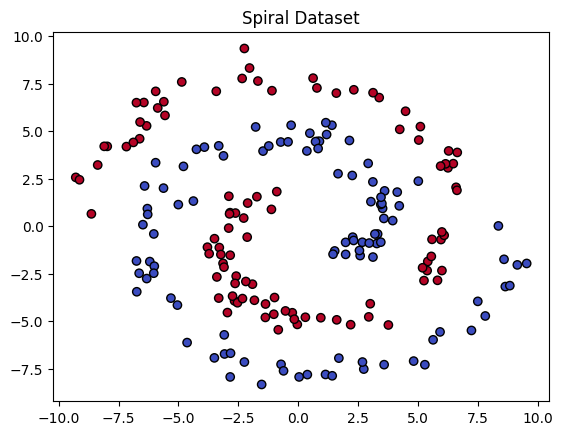

In [35]:
# Step 2: Function to generate the spiral dataset
def make_spiral(n_samples=100):
    np.random.seed(42)

    # Class 0
    t = 0.75 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
    x1 = t * np.cos(t)
    x2 = t * np.sin(t)
    y = np.zeros_like(t)

    # Class 1
    t = 0.75 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
    x1 = np.hstack([-x1, t * np.cos(t)])
    x2 = np.hstack([-x2, t * np.sin(t)])
    y = np.hstack([y, np.ones_like(t)])

    # Concatenate data points for both classes
    X = np.concatenate((x1, x2))
    # Add some noise
    X += 0.50 * np.random.randn(2, 2 * n_samples)

    return X.T, y[0]

# Generate the dataset
X, y = make_spiral(100)

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title("Spiral Dataset")
plt.show()

In [36]:
# Step 3: Define Dataset and DataLoader
class SpiralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = SpiralDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

**Dataset-Klasse:**
- Diese Klasse dient dazu, den Datensatz in einer Art Container zu verpacken, den PyTorch dann verarbeiten kann.
- Die Klasse SpiralDataset erbt von torch.utils.data.Dataset, einer abstrakten Klasse, die genau die zwei Methoden __len__() und __getitem__() implementiert.
- __init__() wird verwendet, um die Daten (Features X und Labels y) zu speichern, wobei sie in Torch-Tensoren umgewandelt werden, was notwendig ist, um sie in PyTorch weiter bearbeiten zu können.
- __len__() gibt die Anzahl der Datenpunkte im Datensatz zurück.
- __getitem__() gibt einen einzelnen Datenpunkt zurück, bestehend aus einem Feature-Vektor und einem Label, basierend auf einem gegebenen Index.

**DataLoader:**
- Der DataLoader ist verantwortlich für das Laden von Daten in Batches und das Shufflen der Daten, falls erwünscht.
- PyTorch's *DataLoader* übernimmt die Aufgabe, die Daten effizient zu laden und stapelweise zu verarbeiten, wodurch das Training beschleunigt wird.
- *DataLoader(dataset, batch_size=32, shuffle=True)* erstellt einen DataLoader, der die Daten aus dem dataset in Batches von 32 Beispielpunkten lädt und die Daten vor jedem Epoche-Training mischt.

In [37]:
# Step 4: Define the Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 2)
        self.softmax = nn.Softmax(dim=1)

        # Initialize weights with normal distribution
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In der aktuellen Vorgehensweise bei der Definition eines neuronalen Netzwerks in PyTorch wird eine Klasse erstellt, die von nn.Module erbt. Innerhalb dieser Klasse werden Layer als Attribute definiert, und die forward()-Methode spezifiziert, wie die Daten durch das Netzwerk fließen:

**Alternative: Pipeline-Architektur**

Eine alternative Methode ist die Verwendung von nn.Sequential, um eine Pipeline-Architektur zu definieren. nn.Sequential erlaubt es, die Layer eines Modells in der Reihenfolge zu spezifizieren, in der die Daten durch diese fließen, ohne eine explizite forward()-Methode zu definieren:

>    model = nn.Sequential(
>    nn.Linear(2, 10),
>    nn.ReLU(),
>    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
    )

Vorteile und Nachteile:

- Benutzerdefinierte Architektur:

- Vorteile: Größere Flexibilität, ermöglicht komplexe Architekturen, bedingte Abläufe und einfacheres Debugging.
- Nachteile: Erfordert mehr Boilerplate-Code, komplexer für Anfänger.
Pipeline-Architektur (nn.Sequential):

Vorteile: Einfacher zu benutzen, ideal für einfache, lineare Architekturen.
Nachteile: Eingeschränkte Flexibilität, schwierig für komplexe Abläufe oder bei der Verwendung von bedingten Operationen.

In [38]:
# Step 5: Instantiate the model, define the loss function and optimizer
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [39]:
# Step 6: Train the model
n_epochs = 1000
for epoch in range(n_epochs):
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

AttributeError: 'NeuralNetwork' object has no attribute 'relu'

In [ ]:
# Step 7: Function to plot decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    with torch.no_grad():
        grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
        Z = model(grid_tensor)
        _, predicted = torch.max(Z, 1)
    Z = predicted.numpy().reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    plt.title("Decision Boundary")
    plt.show()

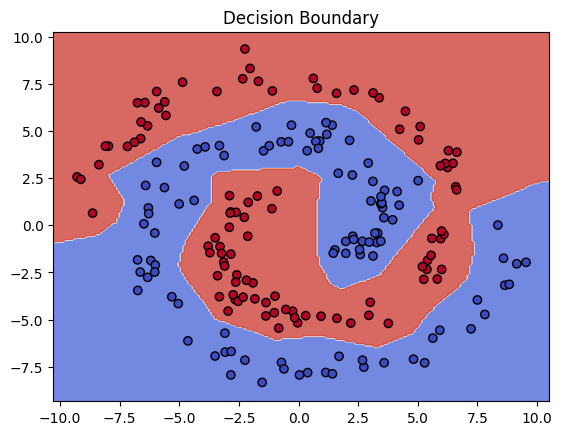

In [ ]:
# Step 8: Plot the decision boundary
plot_decision_boundary(model, X, y)